In [1]:
# -- IMPORTS --
'''
%pip install livelossplot
%pip install torcheval
%pip install torchmetrics
'''
import os
os.chdir('/workplace/flowmind/')
print("working in: " + os.getcwd())

#%run /workplace/flowmind/setup.py

import csv
import sys

# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torcheval.metrics import MulticlassAccuracy
from torchdata.datapipes.iter import FileLister

# flowmind imports
from flowmind.processing.dataloaders.common import FlowData
from flowmind.processing.dataloaders.flowpic import Flowpic

from flowmind.processing.scaler import Scaler
from flowmind.contrastive import NTXentLoss

# livelossplot imports
from livelossplot import PlotLosses
from livelossplot.outputs import MatplotlibPlot

# others
from datetime import timedelta
import random
from functools import partial
from typing import Callable
from pathlib import Path
from functools import partial

os.chdir('/workplace/xcocek00/')
from common import (
    DataPipeTransform,
    FlowDataTransform,
    datapipe_identity,
    filter_csv_filename,
    filter_min_flow_length,
    flowdata_identity,
)

# sets csv limit
csv.field_size_limit(sys.maxsize)

# sets the device to use gpu if available, if not, use cpu
device = torch.device(f"cuda" if torch.cuda.is_available() else "cpu")


working in: /workplace/flowmind


/root/miniconda3/lib/python3.12/site-packages/torchdata/datapipes/__init__.py:18: UserWarning: 
################################################################################
WARNING!
The 'datapipes', 'dataloader2' modules are deprecated and will be removed in a
future torchdata release! Please see https://github.com/pytorch/data/issues/1196
to learn more and leave feedback.
################################################################################

  deprecation_warning()


In [2]:
# -- custom remap_label function --

def remap_label(t: tuple[torch.Tensor, torch.Tensor, str], labels_d: dict[str, int]) -> tuple[torch.Tensor, torch.Tensor, int]:
    return t[0], t[1], labels_d[t[2]]

labels_utmobilenet = [
    "youtube",
    "google-maps",
    "hulu",
    "reddit",
    "spotify",
    "netflix",
    "pinterest",
    "twitter",
    "instagram",
    "hangout",
    "dropbox",
    "pandora",
    "facebook",
    "google-drive",
]

labels_utmobilenet_d = {label: i for i, label in enumerate(labels_utmobilenet)}

remap_label_utmobilenet = partial(remap_label, labels_d=labels_utmobilenet_d)

In [3]:
# -- custom dataloader creating function --

def create_flowpic_dataloader(
    dir_path: Path | str,
    batch_size: int,
    scaler: Scaler | None = None,
    min_packets: int = 0,
    time_bins: list = [0, 37.5, 75.0, 112.5, 150.0, 187.5, 225.0, 262.5, 300.0],
    length_bins: list = [0, 187.5, 375.0, 562.5, 750.0, 937.5, 1125.0, 1312.5, 1500.0],
    ppi_bins: list | None = None,
    normalize: bool = False,
    bidirectional: bool = True,
    meta_key: str | list[str] | None = None,
    dp_transform: DataPipeTransform = datapipe_identity,
    flow_transform_1: FlowDataTransform = flowdata_identity, 
    flow_transform_2: FlowDataTransform = flowdata_identity, 
    num_workers: int = 0,
) -> torch.utils.data.DataLoader:
    """Create torch DataLoader.
       The dataloader creates 2d flowpic from ppi and transform them into tensors.

    Args:
        dir_path (Path | str): Directory with csvs.
        batch_size (int): Batch size.
        scaler (Mapping[str, Scaler] | None, optional): Data scaler to apply. Defaults to None.
        min_packets (int, optional): Minimal flow lengths to include. Defaults to 0.
        time_bins (list, optional): Time bins. Defaults to [0, 37.5, 75.0, 112.5, 150.0, 187.5, 225.0, 262.5, 300.0].
        length_bins (list, optional): Packet size bins. Defaults to [0, 187.5, 375.0, 562.5, 750.0, 937.5, 1125.0, 1312.5, 1500.0].
        ppi_bins (list | None, optional): PPI bins. Defaults to None.
        normalize (bool, optional): Whether to normalize packets in bins instead of absolute counts. Defaults to False.
        bidirectional (bool, optional): Whether to use bidirectional flowpic. Defaults to False.
        meta_key (str | list[str] | None, optional): Target column name. Defaults to None.
        dp_transform(DataPipeTransform, optional): Datapipe transform function. Defaults to identity.
        flow_transform(FlowDataTransform, optional): Flow transform function. Defaults to identity.

    Returns:
        torch.utils.data.DataLoader: Torch DataLoader.
    """

    dp = (
        FileLister(str(dir_path))
        .filter(filter_csv_filename)
        .sharding_filter() 
        .open_files() 
        .parse_csv_as_dict()
        .filter(partial(filter_min_flow_length, threshold=min_packets)) 
        .map(lambda row: (row, row)) # each item in dp is (row, row)
    )

    dp = dp.map(
        partial(
            build_two_augmented_flows,
            flow_transform_1=flow_transform_1,
            flow_transform_2=flow_transform_2,
            time_bins=time_bins,
            length_bins=length_bins,
            ppi_bins=ppi_bins,
            normalize=normalize,
            bidirectional=bidirectional,
            meta_key=meta_key,
            scaler=scaler,
        )
    )

    dp = dp_transform(dp)

    return torch.utils.data.DataLoader(dp.batch(batch_size).collate(), batch_size=None, num_workers=num_workers)

def build_two_augmented_flows(
    pair_of_rows: tuple[dict, dict],
    flow_transform_1,
    flow_transform_2,
    time_bins,
    length_bins,
    ppi_bins,
    normalize,
    bidirectional,
    meta_key,
    scaler=None,
):
    """
    Creates (flowpic1, flowpic2, label) from (row1, row2).
    """
    row1, row2 = pair_of_rows

    # first flow
    flow1 = Flowpic(
        x=row1,
        flow_transform=flow_transform_1,
        time_bins=time_bins,
        length_bins=length_bins,
        ppi_bins=ppi_bins,
        normalize=normalize,
        bidirectional=bidirectional,
        meta_key=meta_key,
    )
    out1 = flow1.export(scaler=scaler)  # => (tensor, label)

    # second flow
    flow2 = Flowpic(
        x=row2,
        flow_transform=flow_transform_2,
        time_bins=time_bins,
        length_bins=length_bins,
        ppi_bins=ppi_bins,
        normalize=normalize,
        bidirectional=bidirectional,
        meta_key=meta_key,
    )
    out2 = flow2.export(scaler=scaler)

    fp1, label = out1    
    fp2, _ = out2

    return fp1, fp2, label


In [4]:
# -- RTT augmentation --

def augment_rtt(flow: FlowData, alpha_min: float = 0.5, alpha_max: float = 1.5) -> FlowData:
    """
    Multiply arrival time of each packet by a factor alpha, where
    alpha is chosen uniformly in [alpha_min, alpha_max]

    Args
        flow: original flow
        alpha_min: min factor set to 0.5
        alpha_max: max factor set to 1.5

    Returns: 
        modified FlowData
    """
    
    if not flow.times:
        return flow

    # select random alpha 
    alpha = random.uniform(alpha_min, alpha_max)
    init_time = flow.init_time

    # convert time to float offset
    offsets = [(t - init_time).total_seconds() for t in flow.times]
    
    # RTT augmentation
    offsets = [offset * alpha for offset in offsets]

    # convert back
    flow.times = [init_time + timedelta(seconds=offset) for offset in offsets]

    return flow


In [5]:
# -- IAT augmentation --

def augment_iat(flow: FlowData, b_min: float = -1.0, b_max: float = 1.0) -> FlowData:
    '''
    Add factor b to the arrival time of each packet, where
    b is chosen uniformly in [b_min, b_max]

    Args:
        flow: original flow
        b_min: min factor set to -1.0 
        b_max: max factor set to 1.0

    Returns: 
        modified FlowData
    '''
    
    if not flow.times:
        return flow
    #print("original times: ", flow.times)

    # calculate time
    # FIXME: delete
    #f_time = flow.times[-1] - flow.times[0]
    #print("flow_time: ", f_time)
    
    # select random b 
    b = random.uniform(b_min, b_max)
    init_time = flow.init_time

    # convert time to float offset
    offsets = [(t - init_time).total_seconds() for t in flow.times]
    
    # IAT augmentation
    offsets = [offset + b for offset in offsets]

    # convert back
    flow.times = [init_time + timedelta(seconds=offset) for offset in offsets]

    return flow

In [6]:
# -- packet loss augmentation --

def packet_loss(flow: FlowData, dt: float = 0.1) -> FlowData:
    '''
    Packet loss augmentation - removing all packets within [t - dt, t + dt]
    
    Args:
        flow: original flow
        dt: delta t (interval length) set to 0.1
    
    Returns: 
        modified Flow with removed packets in that interval
    ''' 

    if not flow.times:
        return flow
    
    init_time = flow.init_time 
    
    # conver to offset
    offsets = [(t - init_time).total_seconds() for t in flow.times]
    flow_duration = offsets[-1] if offsets else 0.0

    # zero or near-zero duration -> skip (would remove the whole flow)
    # TODO: consider 2*dt
    if flow_duration <= 0:
        return flow

 
    t = random.uniform(0, flow_duration)

    # interval [t - dt, t + dt]
    lower = t - dt
    upper = t + dt

    # lists for filtered packets
    new_directions = []
    new_lengths    = []
    new_times      = []
    new_push_flags = []

    for offset, direction, length, time_val, push_flag in zip(offsets, flow.directions, flow.lengths, flow.times, flow.push_flags):
        if not (lower <= offset <= upper):
            new_directions.append(direction)
            new_lengths.append(length)
            new_times.append(time_val)
            new_push_flags.append(push_flag)

    # replace old lists with the fitered lists
    flow.directions = new_directions
    flow.lengths    = new_lengths
    flow.times      = new_times
    flow.push_flags = new_push_flags
    flow.init_time  = flow.times[0] if flow.times else None

    return flow


In [7]:
# -- TESTS --

# dimensions validation
def dim_val(dl_train: torch.utils.data.DataLoader) -> None:
    print("dl train: ", type(dl_train), file=sys.stderr)
    for (flowpic1, flowpic2, labels) in dl_train:
        print("flowpic1", type(flowpic1), file=sys.stderr)
        print("flowpic2", type(flowpic2), file=sys.stderr)
        print("flowpic1 shape: ", flowpic1.shape, file=sys.stderr)
        print("flowpic2 shape: ", flowpic2.shape, file=sys.stderr)
        break    

# print batch
def print_batch(dl_train: torch.utils.data.DataLoader, type: str) -> None:
    for batch in dl_train:
        torch.set_printoptions(threshold=sys.maxsize)
        print("printing " + type + " batch ...,", file=sys.stderr)
        print(batch, file=sys.stderr)
        break
    
# debug batch    
def debug_batch(dl: torch.utils.data.DataLoader) -> None:
    for (flowpic1, flowpic2, labels) in dl:
        print("flowpic1 type:", type(flowpic1), file=sys.stderr)
        print("flowpic2 type:", type(flowpic2), file=sys.stderr)
        print("label type:", type(labels), file=sys.stderr)
        
        if isinstance(flowpic1, list):
            print(f"flowpic1 has {len(flowpic1)} items.", file=sys.stderr)
            print("Shapes of flowpic1 items:", file=sys.stderr)
            for i, fp in enumerate(flowpic1):
                print(type(fp), file=sys.stderr)
                print(f"  Item {i}: {fp.shape}", file=sys.stderr)
                break

        if isinstance(flowpic2, list):
            print(f"flowpic2 has {len(flowpic2)} items.", file=sys.stderr)
            print("Shapes of flowpic2 items:", file=sys.stderr)
            for i, fp in enumerate(flowpic2):
                print(f"  Item {i}: {fp.shape}", file=sys.stderr)

        print("labels:", labels, file=sys.stderr)
        break  # Just inspect the first batch
    



In [8]:
# -- DATA LOADERS for utmobilenet --
# dataloaders yield tuple (flowpic1, flowpic2, label)
# using only 15 seconds of the flow
# TODO: vyresit vyber augmentaci

# 0 - debug prints are turned off
# 1 - debug prints are turned on
DEBUG = 1

# dataloader used for training
dl_train = create_flowpic_dataloader(
    dir_path="/workplace/datasets/utmobilenet21/final-splits/train.csv",
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    flow_transform_1=augment_rtt,
    flow_transform_2=augment_rtt,
    bidirectional = False,
    min_packets=5,
    dp_transform=lambda dp: dp.map(remap_label_utmobilenet).in_memory_cache(),
)

# dataloader used for validation
dl_val = create_flowpic_dataloader(
    dir_path="/workplace/datasets/utmobilenet21/final-splits/val.csv",
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    flow_transform_1=augment_rtt,
    flow_transform_2=augment_rtt,
    bidirectional = False,    
    min_packets=5,
    dp_transform=lambda dp: dp.map(remap_label_utmobilenet).in_memory_cache(),
)

# dataloader used for classification head
dl_class = create_flowpic_dataloader(
    dir_path="/workplace/datasets/utmobilenet21/final-splits/train.csv",
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    bidirectional = False,   
    min_packets=5,
    dp_transform=lambda dp: dp.map(remap_label_utmobilenet).in_memory_cache(),
)

# dataloader used for unseen data to test model
dl_test = create_flowpic_dataloader(
    dir_path="/workplace/datasets/utmobilenet21/final-splits/test.csv",
    batch_size=32,
    meta_key="app",
    time_bins = [i * (15 / 32) for i in range(33)],
    length_bins = [i * (1500 / 32) for i in range(33)],
    bidirectional = False,   
    min_packets=5,
    dp_transform=lambda dp: dp.map(remap_label_utmobilenet).in_memory_cache(),
)


if DEBUG:    
    #print(type(dl_train))
    #dim_val(dl_train)
    print_batch(dl_train, "training")
    print_batch(dl_class, "classification")
    #debug_batch(dl_train)

/root/miniconda3/lib/python3.12/site-packages/torch/utils/data/datapipes/utils/common.py:145: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(
printing training batch ...,
[tensor([[[[3.9000e+01, 2.0000e+00, 3.0000e+00, 0.0000e+00, 0.0000e+00,
           1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 7.2000e+01, 0.0000e+00,
           0.0000e+00, 0.0000e+00],
          [0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
           0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

In [9]:
# -- CNN architecture --     
  
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Flatten(),
            nn.Linear(400, 120),
            nn.ReLU(),
            #nn.Dropout(0.25),
        )

        self.projection = nn.Sequential(
            nn.Linear(120,120),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Linear(120,30),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.projection(x)
        x = F.normalize(x, p=2, dim=1)
        return x
    
    

In [10]:
# -- fine tuning using linear classifier --

class MLP(nn.Module):
    def __init__(self, output_size: int, input_size=120):
        super().__init__()

        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        y = self.fc(x)
        return y


In [11]:
# -- training loops--

def train(model, dataloader, optimizer, contrastive_loss_fn, log):
    '''
    Training loop

    Args:
        model: CNN model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        optimizer: chosen optimizer
        contrastive_loss_fn: contrastive loss function (NT-Xent)
        log: for log collection

    Returns:
        Avarage loss 
    '''

    model.train()
    total_loss = 0.0
    batches = 0

    # label not needed in -> _
    for flowpic1, flowpic2, _ in dataloader:
        flowpic1, flowpic2 = flowpic1.to(device), flowpic2.to(device)

        optimizer.zero_grad()

        z1 = model(flowpic1)
        z2 = model(flowpic2)
        
        # contrastive loss
        loss = contrastive_loss_fn(z1, z2)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1
        
    total_loss /= batches
    log["loss"] = total_loss

    return total_loss

def val(model, dataloader, contrastive_loss_fn, log):
    '''
    Validation loop

    Args:
        model: CNN model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        contrastive_loss_fn: contrastive loss function (NT-Xent)
        log: for log collection

    Returns:
        Avarage loss 
    '''
    with torch.no_grad():
        model.eval()
        total_loss = 0.0
        batches = 0

        # label not needed in -> _
        for flowpic1, flowpic2, _ in dataloader:
            flowpic1, flowpic2 = flowpic1.to(device), flowpic2.to(device)

            z1 = model(flowpic1)
            z2 = model(flowpic2)
            
            # contrastive loss
            loss = contrastive_loss_fn(z1, z2)

            total_loss += loss.item()
            batches += 1

        total_loss /= batches
        log["val_loss"] = total_loss

    return total_loss

def classification(CNN_model, MLP_model, dataloader, log, loss_fn, accuracy, optimizer):
    '''
    Classification loop

    Args:
        CNN_model: CNN model 
        MLP_model: MLP model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        log: for log collection
        loss_fn: chosen loss function
        accuracy: chosen model accuracy
        optimizer: chosen optimizer

    Returns:
        classification loss 
    '''

    # freeze the encoder
    for param in CNN_model.encoder.parameters():
        param.requires_grad = False

    # remove projection head
    CNN_model.projection = nn.Sequential()
    
    # set models
    CNN_model.eval()
    MLP_model.train()

    classification_loss = 0.0
    batches = 0

    for flowpic, _, label in dataloader:
        optimizer.zero_grad()

        flowpic, label = flowpic.to(device), label.to(device)

        with torch.no_grad():
            embeddings = CNN_model.encoder(flowpic)
        
        y_pred = MLP_model(embeddings)

        loss = loss_fn(y_pred, label)
        loss.backward()
        optimizer.step()

        classification_loss += loss.item()
        batches += 1
        
        accuracy.update(y_pred, label)
    
    classification_loss /= batches

    log["classification_loss"] = classification_loss
    log["accuracy"] = accuracy.compute()
        
    accuracy.reset()

    return classification_loss

def testing(CNN_model, MLP_model, dataloader, log, loss_fn, accuracy):
    '''
    Testing loop

    Args:
        CNN_model: CNN model 
        MLP_model: MLP model
        dataloader: pytorch dataloader created by create_flowpic_dataloader function
        log: for log collection
        loss_fn: chosen loss function
        accuracy: chosen model accuracy
        optimizer: chosen optimizer

    Returns:
        training loss 
    '''

    # freeze the encoder
    for param in CNN_model.encoder.parameters():
        param.requires_grad = False
    
    # set models
    CNN_model.eval()
    MLP_model.eval()

    test_loss = 0.0
    batches = 0

    with torch.no_grad():
        for flowpic_t, _, label_t in dataloader:
            flowpic_t, label_t = flowpic_t.to(device), label_t.to(device)

            embeddings = CNN_model.encoder(flowpic_t)
            y_pred = MLP_model(embeddings)

            loss = loss_fn(y_pred, label_t)
            test_loss += loss.item()
            batches += 1

            accuracy.update(y_pred, label_t)
    
        test_loss /= batches
    
        log["test_loss"] = test_loss
        log["test_accuracy"] = accuracy.compute()
            
        accuracy.reset()

    return test_loss



In [12]:
# -- utmobilenet21 dataset --

classes = 14

# CNN definition
cnn_model = CNN()
cnn_model = cnn_model.to(device)

# optimizer
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

# NT-Xent loss function
contrastive_loss_fn = NTXentLoss(temperature=0.07)

cnn_liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])

# Linear classifier definition
mlp_model = MLP(classes)
mlp_model = mlp_model.to(device)

# optimizer
mlp_optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01)

# loss function
mlp_loss_fn = nn.CrossEntropyLoss()

mlp_accuracy = MulticlassAccuracy()

mlp_liveloss = PlotLosses(outputs=[MatplotlibPlot(cell_size=(6, 2))])

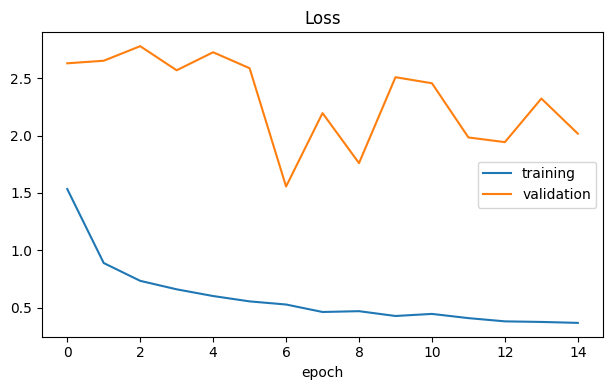

In [13]:
# -- traning CNN --

for epoch in range(15):
    log = {}
    train_loss = train(cnn_model, dl_train, cnn_optimizer, contrastive_loss_fn, log)
    val_loss = val(cnn_model, dl_val, contrastive_loss_fn, log)

    cnn_liveloss.update(log)
    cnn_liveloss.send()

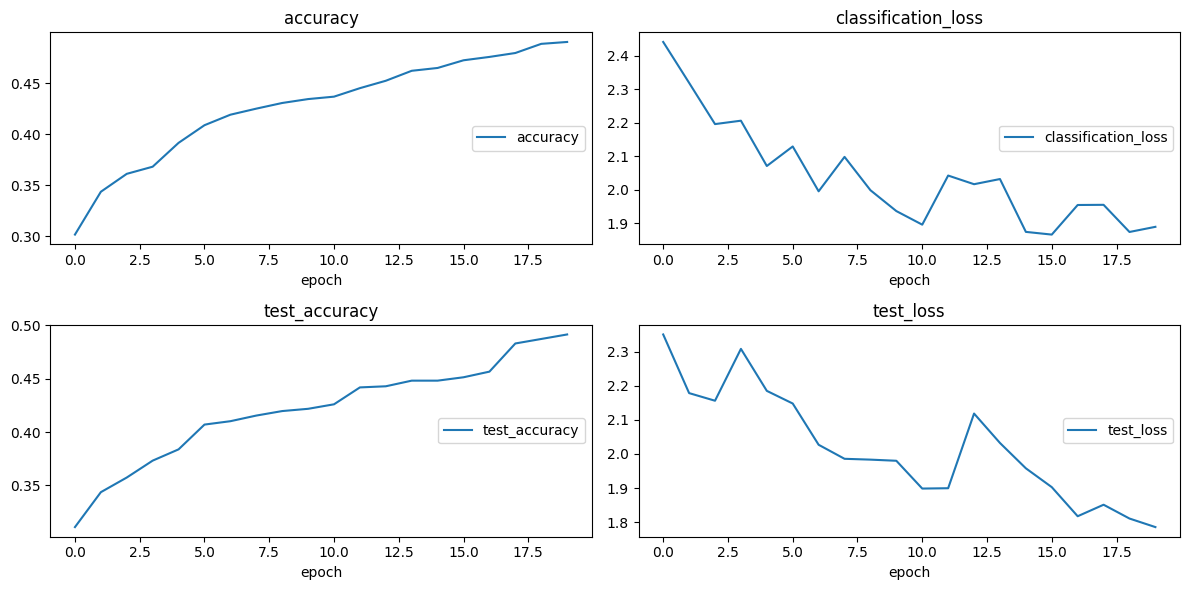

In [14]:
# -- training linear classifier --

# set params for early stopping
best_loss = float('inf')
no_improvement = 0
min_improvement = 0.001
patience = 5

for epoch in range(20):
    log = {}
    classification_loss = classification(cnn_model, mlp_model, dl_class, log, mlp_loss_fn, mlp_accuracy, mlp_optimizer)   
    test = testing(cnn_model, mlp_model, dl_test, log, mlp_loss_fn, mlp_accuracy)   

    mlp_liveloss.update(log)
    mlp_liveloss.send()

    # early stopping
    if best_loss - classification_loss > min_improvement:
        best_loss = classification_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= patience:
        print("Early stopping - epoch ", epoch)
        break
    